# Restaurant Review - Sentiment Analysis

Analyzing the  Restaurant Reviews dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

# Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import pickle
import re
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis

In [ ]:
#Load the data

data = pd.read_csv("/content/Restaurant reviews.csv")

print(f"Dataset shape : {data.shape}")

Dataset shape : (10000, 7)


In [ ]:
data.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [ ]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['Restaurant' 'Reviewer' 'Review' 'Rating' 'Metadata' 'Time' 'Pictures']


# Handle Null Values

In [ ]:
#Check for null values

data.isnull().sum()

Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

#### We will delete these Four columns becuase they are unneccesary.

In [ ]:
columns_to_drop = ['Metadata', 'Time', 'Pictures' , 'Reviewer']

# Drop the columns
data = data.drop(columns=columns_to_drop)

In [ ]:
data.head(5)

,Restaurant,Review,Rating
0,Beyond Flavours,"The ambience was good, food was quite good . h...",5
1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,5
2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,5
3,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,5
4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,5


####we will delete the rows where Review and Rating is Null Because these two are the main columns.

In [ ]:


# Dropping rows where the 'Review' column is null
data = data.dropna(subset=['Review'])


In [ ]:

# Dropping rows where the 'Review' column is null
data = data.dropna(subset=['Rating'])

In [ ]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (9955, 3)


In [ ]:
#Creating a new column 'length' that will contain the length of the string in 'Reviews' column

data['length'] = data['Review'].apply(len)

In [ ]:
data.head()

,Restaurant,Review,Rating,length
0,Beyond Flavours,"The ambience was good, food was quite good . h...",5,222
1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,5,144
2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,5,189
3,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,5,148
4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,5,160


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [ ]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['Review']}") #Original value
print(f"Length of review : {len(data.iloc[10]['Review'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: The service was great and the food was awesome. The service staff Manab and Papiya were very courteous and attentive. I would like to come frequently to this place
Length of review : 163
'length' column value : 163


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [ ]:
data.dtypes

Restaurant    object
Review        object
Rating        object
length         int64
dtype: object

# Analyzing 'Rating' column

This column refers to the rating of the variation given by the user

In [ ]:
#Distinct values of 'rating' and its count

print(f"Rating value count: \n{data['Rating'].value_counts()}")

Rating value count: 
Rating
5       3826
4       2373
1       1735
3       1192
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: count, dtype: int64


The Rating Column Contain one character value that is "Like" Lets check what is in the review for that rating

In [ ]:
data[data['Rating'] == 'Like']['Review']


7601    One of the best pizzas to try. It served with ...
Name: Review, dtype: object

In [ ]:
# Replace 'Like' with 5 in the 'Rating' column
data['Rating'] = data['Rating'].replace('Like', 5)

In [ ]:
data['Rating'] = pd.to_numeric(data['Rating'], errors='coerce')

In [ ]:
print(f"Rating value count: \n{data['Rating'].value_counts()}")

Rating value count: 
Rating
5.0    3827
4.0    2373
1.0    1735
3.0    1192
2.0     684
4.5      69
3.5      47
2.5      19
1.5       9
Name: count, dtype: int64


Let's plot the above values in a bar graph

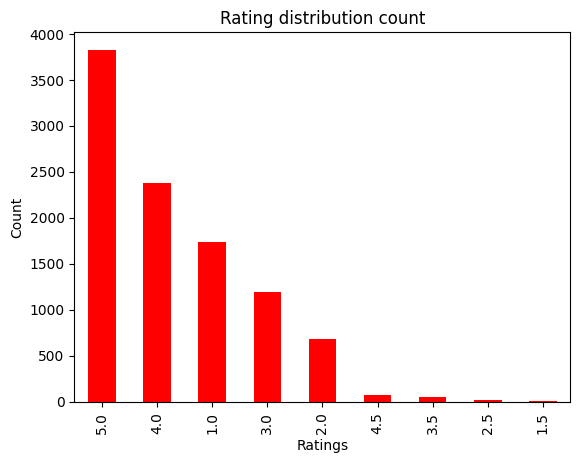

In [ ]:
#Bar plot to visualize the total counts of each rating

data['Rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['Rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
Rating
5.0    38.44
4.0    23.84
1.0    17.43
3.0    11.97
2.0     6.87
4.5     0.69
3.5     0.47
2.5     0.19
1.5     0.09
Name: count, dtype: float64


#### Now we will create a new column name Feedback so that we can differentiate our positive and negative review  based on ratings

In [ ]:
# Define a function to categorize ratings
def categorize_rating(rating):
    if rating >= 3.5:
        return 1
    else:
        return 0

# Apply this function to create a new column
data['Feedback'] = data['Rating'].apply(categorize_rating)


# Analyzing 'feedback' column

This column refers to the feedback of the verified review

In [ ]:
# Check the data type of the 'Feedback' column
print(data['Feedback'].dtype)


int64


In [ ]:
#Distinct values of 'feedback' and its count

print(f"Feedback value count: \n{data['Feedback'].value_counts()}")

Feedback value count: 
Feedback
1    6316
0    3639
Name: count, dtype: int64


There are 2 distinct values of 'feedback' present - 0 and 1. Let's see what kind of review each value corresponds to.

feedback value = 0

In [ ]:
#Extracting the 'verified_reviews' value for one record with feedback = 0

data[data['Feedback'] == 0].iloc[1]['Review']


"Short review: Decent breads and starters, bad Shaam Savera, a little screwed up daal makhni (but should be a one-off case)\nBetter ambience at night... And importantly good quantity!\nI wanted to give a 2.5 but that's not an option 🙈\nExtensive...\nAmbience: It's better at night. Friends who had been here during the day didn't like it much. So if you prefer ambience, go at night!\nFood! Ordered a Hara Bhara Kebab, Shaam Savera, Daal Makhni, rotis and raita (Yes! I'm a vegetarian 🙈)\nThe good part! Quantity 😍\nI was excited to see Shaam Savera on their menu. But take it from me, you do not want to order it. It is no where close to what it should be. They messed it up real bad, especially the colors.\nThe daal makhni had big chunks of garlic cloves which spoiled it for me. It wasn't creamy too :(\nThe breads and raita were decent!\nThe Hara Bhara Kebabs were decent too, soft! They had an extra outer coating of peanuts. So if you're not a peanut fan on your kebabs, ask them to skip that 

In [ ]:
#Extracting the 'verified_reviews' value for one record with feedback = 1

data[data['Feedback'] == 1].iloc[1]['Review']

'Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service'

From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

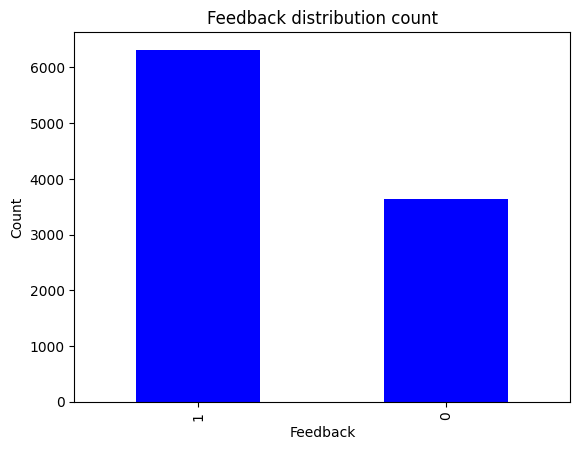

In [ ]:
#Bar graph to visualize the total counts of each feedback

data['Feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [ ]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(data['Feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
Feedback
1    63.45
0    36.55
Name: count, dtype: float64


Feedback distribution <br>
*  63.45% reviews are positive <br>
*  36.55% reviews are negative

<Axes: ylabel='Percentage wise distrubution of feedback'>

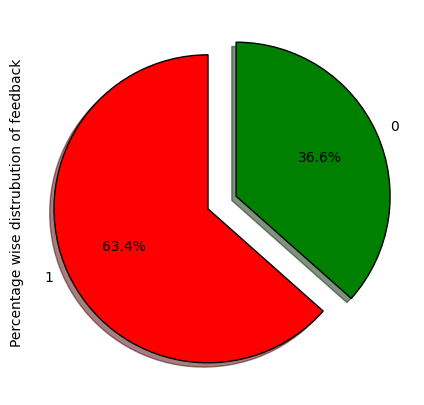

In [ ]:
fig = plt.figure(figsize=(5,5))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['Feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

Let's see the 'rating' values for different values of 'feedback'

In [ ]:
#Feedback = 0
data[data['Feedback'] == 0]['Rating'].value_counts()

Rating
1.0    1735
3.0    1192
2.0     684
2.5      19
1.5       9
Name: count, dtype: int64

In [ ]:
#Feedback = 1
data[data['Feedback'] == 1]['Rating'].value_counts()

Rating
5.0    3827
4.0    2373
4.5      69
3.5      47
Name: count, dtype: int64

##### If rating of a review is 1.0 , 1.5 , 2.0 , 2.5 or 3 then the feedback is 0 (negative) and if the rating is 3.5, 4.0 , 4.5 or 5.0 then the feedback is 1 (positive).

## Analyzing 'Restaurant' column

This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [ ]:
#Distinct values of 'variation' and its count

print(f"Variation value count: \n{data['Restaurant'].value_counts()}")

Variation value count: 
Restaurant
Beyond Flavours               100
PourHouse7                    100
Urban Asia - Kitchen & Bar    100
The Indi Grill                100
The Tilt Bar Republic         100
                             ... 
Being Hungry                   99
Olive Garden                   99
Hyderabad Chefs                98
Arena Eleven                   85
American Wild Wings            77
Name: count, Length: 100, dtype: int64


In [ ]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records

print(f"Variation value count - percentage distribution: \n{round(data['Restaurant'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
Restaurant
Beyond Flavours               1.00
PourHouse7                    1.00
Urban Asia - Kitchen & Bar    1.00
The Indi Grill                1.00
The Tilt Bar Republic         1.00
                              ... 
Being Hungry                  0.99
Olive Garden                  0.99
Hyderabad Chefs               0.98
Arena Eleven                  0.85
American Wild Wings           0.77
Name: count, Length: 100, dtype: float64


Mean rating according to variation

In [ ]:
data.groupby('Restaurant')['Rating'].mean()

Restaurant
10 Downing Street                        3.80
13 Dhaba                                 3.48
3B's - Buddies, Bar & Barbecue           4.76
AB's - Absolute Barbecues                4.88
Absolute Sizzlers                        3.62
                                         ... 
Urban Asia - Kitchen & Bar               3.65
Yum Yum Tree - The Arabian Food Court    3.56
Zega - Sheraton Hyderabad Hotel          4.45
Zing's Northeast Kitchen                 3.65
eat.fit                                  3.20
Name: Rating, Length: 100, dtype: float64

Let's analyze the above ratings

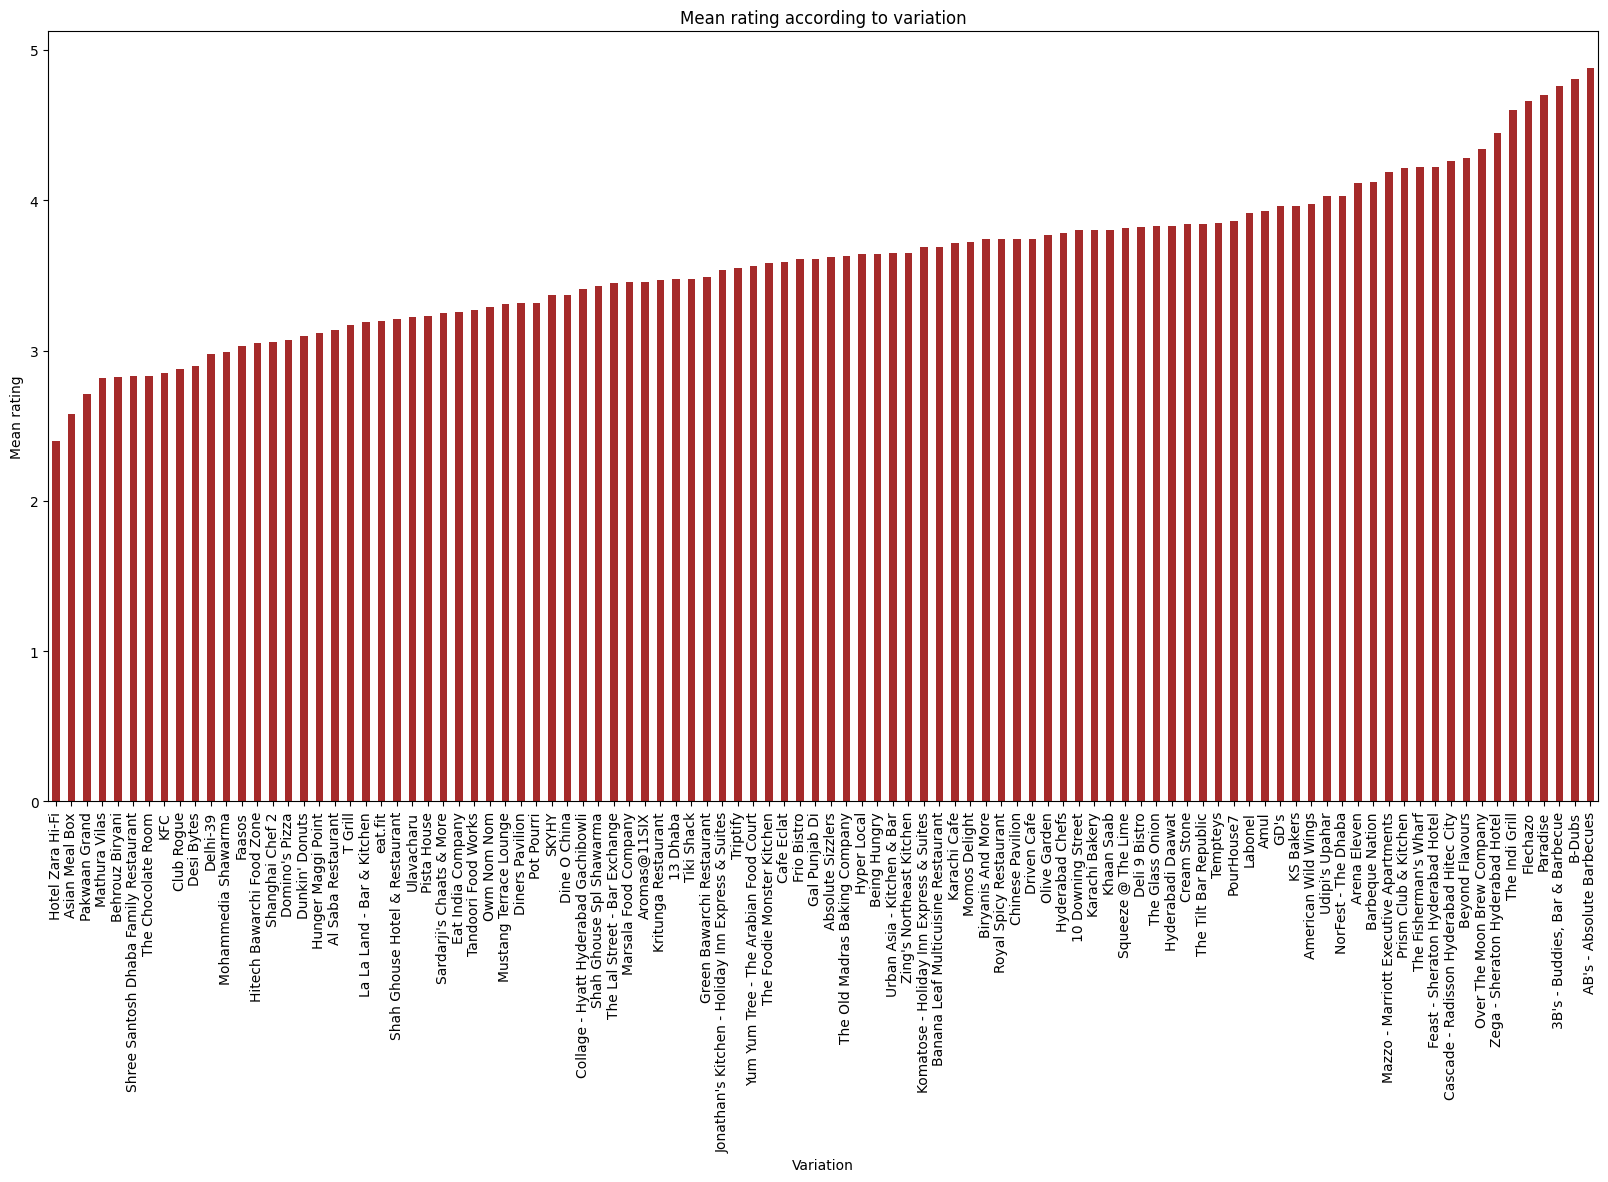

In [ ]:
data.groupby('Restaurant')['Rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(20, 10))
plt.title("Mean rating according to variation")
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

# Analyzing 'Review' column

This column contains the textual review given by the user for a variation for the product.

In [ ]:
data['length'].describe()

count    9955.000000
mean      279.674736
std       338.506494
min         1.000000
25%       144.000000
50%       189.000000
75%       321.000000
max      5212.000000
Name: length, dtype: float64

Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review ')]

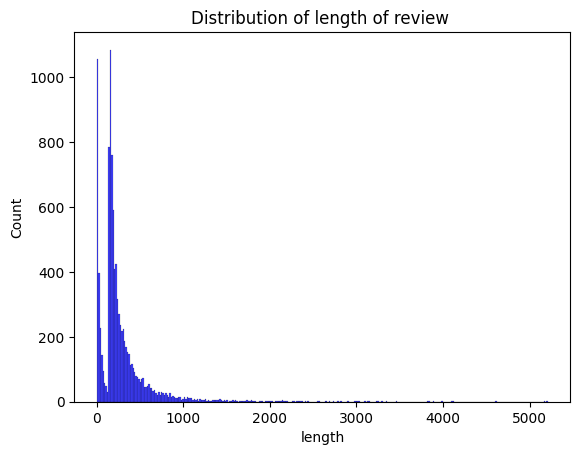

In [ ]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

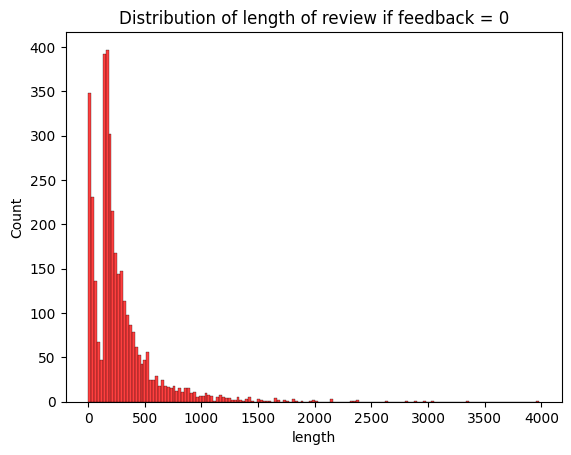

In [ ]:
sns.histplot(data[data['Feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

Length analysis when feedback is 1 (positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

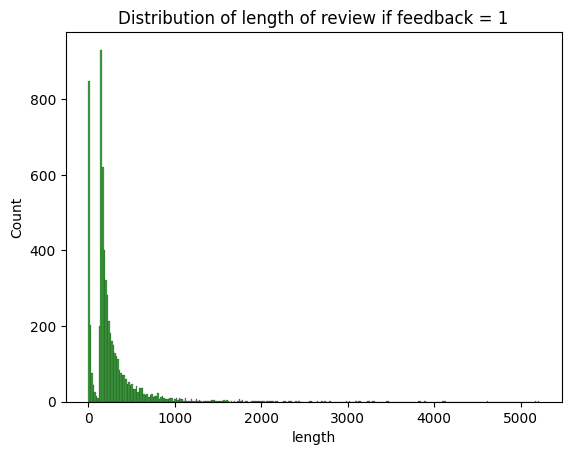

In [ ]:
sns.histplot(data[data['Feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

Lengthwise mean rating

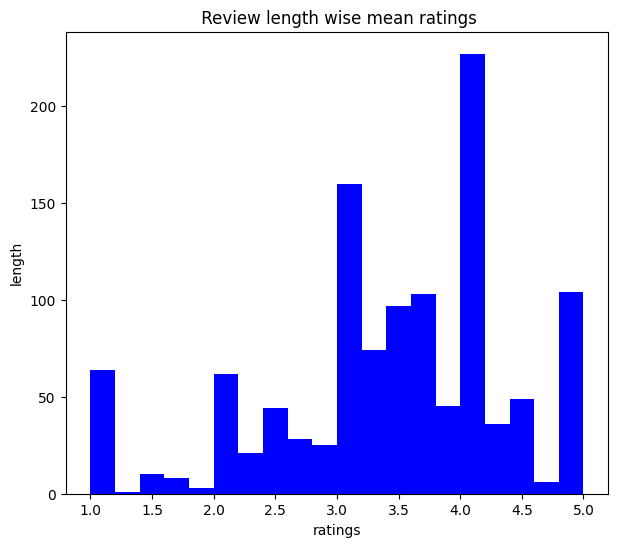

In [ ]:
data.groupby('length')['Rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

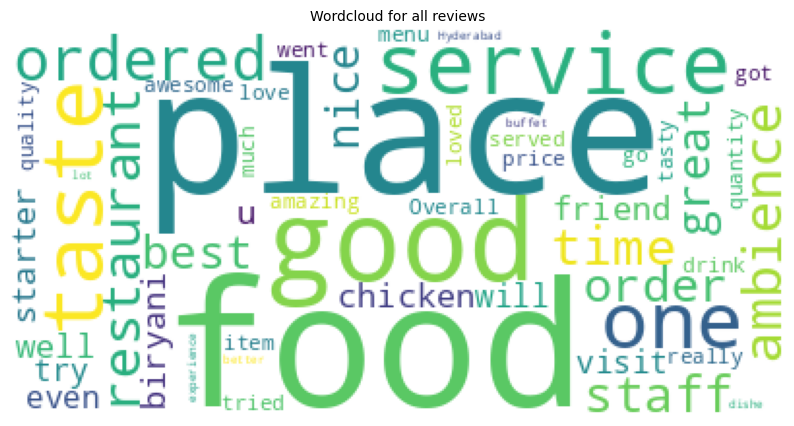

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in data['Review']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

Lets find the unique words in each feedback category

In [ ]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['Feedback'] == 0]['Review']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['Feedback'] == 1]['Review']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


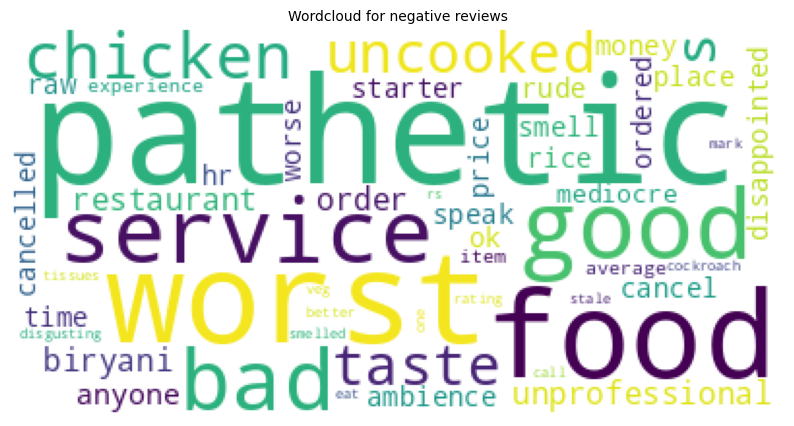

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

Negative words can be seen in the above word cloud - bad, unprofessional,  uncooked, disgusting etc

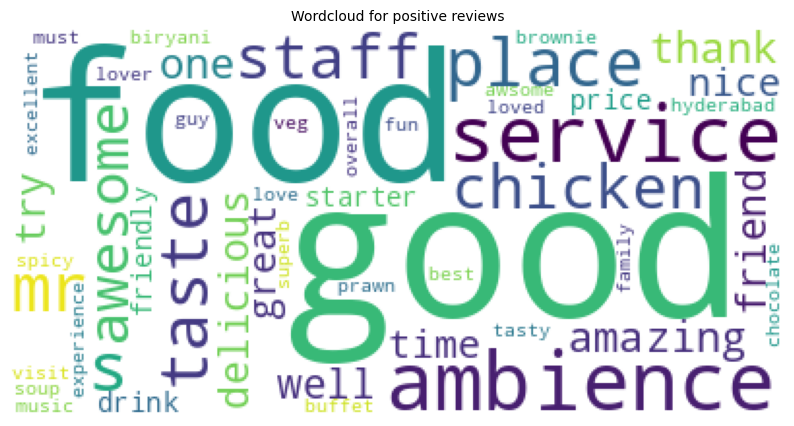

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

Positive words can be seen in the above word cloud - good, well, amazing, best, great etc

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [ ]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['Review'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to TF IDF

In [ ]:
vectorizer =   TfidfVectorizer(max_features = 2500)
#Storing independent and dependent variables in X and y
X = vectorizer.fit_transform(corpus).toarray()
y = data['Feedback'].values

Checking the shape of X and y

In [ ]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 30% data with testing.

In [ ]:
indices = np.arange(X.shape[0])

X_train, X_test, y_train, y_test , idx_train, idx_test = train_test_split(X, y,indices, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (6968, 2500)
y train: (6968,)
X test: (2987, 2500)
y test: (2987,)


In [ ]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 1.0
X test max value: 1.0


We'll scale X_train and X_test so that all values are between 0 and 1.

In [ ]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

# XgBoost

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9520665901262916
Testing Accuracy : 0.867425510545698


In [ ]:

y_preds = model_xgb.predict(X_test_scl)

In [ ]:
def print_metrics(title, y_true, y_pred, plot_name):
    print(title)
    print(y_true.dtype)
    print(y_pred.dtype)
    y_true = y_true.astype(int)  # Convert to integer if y_true is string
    y_pred = y_pred.astype(int)  # Convert to integer if y_pred is string

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
    cm_display.plot()
    plt.show()

    # Plot precision, recall, and F1-score
    num_classes = len(precision)
    model_labels = [f'{i}' for i in range(num_classes)]

    plt.figure(figsize=(6, 3))
    for i, metric_value in enumerate([precision, recall, f1], 1):
        plt.subplot(1, 3, i)
        plt.bar(model_labels, metric_value, color=['blue', 'green', 'red'])
        plt.title(['Precision', 'Recall', 'F1 Score'][i-1])
        plt.xlabel('Classes')
        plt.ylabel('Score')
        plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig(f'{plot_name}_metrics_plot.png')
    plt.show()

    # Print classification report
    print()
    report = classification_report(y_true, y_pred)
    print("Classification Report:")
    print(report)

Random Forest Metrics:
int64
int64
Accuracy: 0.867425510545698
Precision: [0.82701652 0.8886619 ]
Recall: [0.79607109 0.90719499]
F1 Score: [0.81124881 0.89783282]
Confusion Matrix:
[[ 851  218]
 [ 178 1740]]
[[ 851  218]
 [ 178 1740]]


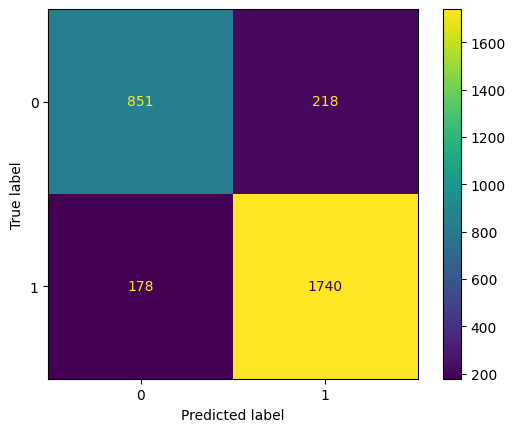

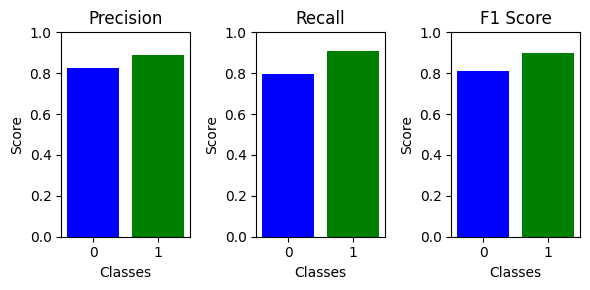


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1069
           1       0.89      0.91      0.90      1918

    accuracy                           0.87      2987
   macro avg       0.86      0.85      0.85      2987
weighted avg       0.87      0.87      0.87      2987



In [ ]:
print_metrics("XgBoost  Metrics:", y_test, y_preds , "XgBoost")

## Get Result Values

In [ ]:
test_texts = [corpus[i] for i in idx_test]

results_df = pd.DataFrame({
    'Text': test_texts,
    'Actual Label': y_test,
    'Predicted Label': y_preds
})
results_df.to_csv('prediction_results.csv', index=False)
